<a href="https://colab.research.google.com/github/CuriousLady/Capstone_AIML_Group2/blob/main/Distilgpt_Tuning_Group2_QA_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall transformers accelerate -y
!pip install transformers[torch] accelerate -U
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install nltk
!pip install rouge-score
%pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f92acabd90a71aebb79d7fba535b5c6c17afc16b26ab1a1c6062a9448ec320c3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

In [ ]:
import torch
import evaluate
from nltk.translate.bleu_score import corpus_bleu
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from nltk.metrics.distance import edit_distance
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import glob
import sacrebleu
import math


In [ ]:
!pip install --upgrade -q gspread
!pip install gspread-dataframe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 503.5 kB/s eta 0:00:00


In [ ]:
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# Load data into a DataFrame
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/12Zx4rJZhiKXHrueCWMccgq-Jpnx8k9F_WdHA6o4O6NI/edit#gid=0'
sh = gc.open_by_url(spreadsheet_url)  # or gc.open_by_key(spreadsheet_key)

worksheet = sh.get_worksheet(0)  # You can specify the worksheet index (0-based)

# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Convert the data into a DataFrame
df = pd.DataFrame(data[1:], columns=data[0])

# Print the DataFrame or perform other operations
print(df.head())

                                            question  \
0  What is the difference between concatenation v...   
1  What is the difference between concatenation v...   
2      Why are derivatives substracted from weights?   
3      Why are derivatives substracted from weights?   
4  Describe a process/pipeline for generating rep...   

                                              answer  
0  Concatenation combines two tensors by adding t...  
1  Concatenation is often used to combine differe...  
2  The derivative of the loss function at a point...  
3  The intuition behind adjusting the weights by ...  
4  Select a pretrained model suitable for the tas...  


In [ ]:
df.head()

,question,answer
0,What is the difference between concatenation v...,Concatenation combines two tensors by adding t...
1,What is the difference between concatenation v...,Concatenation is often used to combine differe...
2,Why are derivatives substracted from weights?,The derivative of the loss function at a point...
3,Why are derivatives substracted from weights?,The intuition behind adjusting the weights by ...
4,Describe a process/pipeline for generating rep...,Select a pretrained model suitable for the tas...


In [ ]:
df.describe()

,question,answer
count,1316,1316
unique,641,1310
top,Does the same hypothesis apply even when its u...,The difference is in their modalities. NLP dea...
freq,6,3


In [ ]:
df["Prompt"] = "Question: " + df["question"] + " Answer: " + df["answer"]

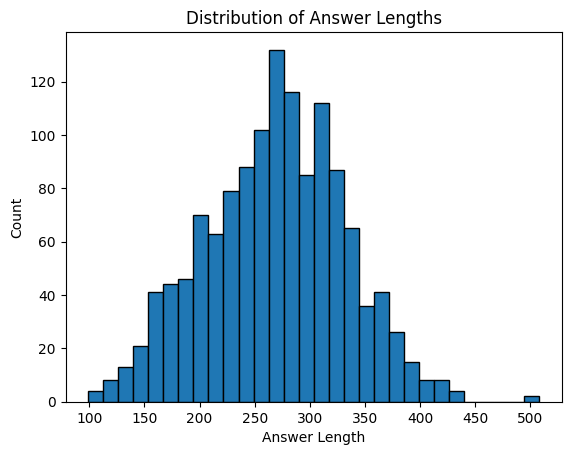

In [ ]:
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df' and the email bodies are stored in the 'Body' column
body_lengths = df['Prompt'].apply(len)

# Plotting the histogram
plt.hist(body_lengths, bins=30, edgecolor='black')
plt.xlabel('Answer Length')
plt.ylabel('Count')
plt.title('Distribution of Answer Lengths')
plt.show()


In [ ]:
df.head()

,question,answer,Prompt
0,What is the difference between concatenation v...,Concatenation combines two tensors by adding t...,Question: What is the difference between conca...
1,What is the difference between concatenation v...,Concatenation is often used to combine differe...,Question: What is the difference between conca...
2,Why are derivatives substracted from weights?,The derivative of the loss function at a point...,Question: Why are derivatives substracted from...
3,Why are derivatives substracted from weights?,The intuition behind adjusting the weights by ...,Question: Why are derivatives substracted from...
4,Describe a process/pipeline for generating rep...,Select a pretrained model suitable for the tas...,Question: Describe a process/pipeline for gene...


In [ ]:
# Load data into a DataFrame
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/11OuouHrRl84nCN4dP2E30Ju5xtSRZ4P2GAS-dpgZCa4/edit#gid=0'
sh = gc.open_by_url(spreadsheet_url)  # or gc.open_by_key(spreadsheet_key)

worksheet = sh.get_worksheet(0)  # You can specify the worksheet index (0-based)

# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Convert the data into a DataFrame
df_dev = pd.DataFrame(data[1:], columns=data[0])

# Print the DataFrame or perform other operations
print(df_dev.head())

                                            question  \
0    How we can effectively convert 2D images to 1D?   
1  Can we utilize an autoencoder to perform dimen...   
2  What is NLP's current biggest challenge that i...   
3  Which problems cannot be solved by Neural netw...   
4                      Is scaling necessary for SVM?   

                                             answer1  \
0  Converting images to 1D data may not be effect...   
1  Yes, autoencoders can be applied to numerical ...   
2  The main challenges of NLP is finding and coll...   
3  While neural networks have shown great success...   
4  Yes, scaling the input data is generally recom...   

                                             answer2  
0  To effectively convert 2D images to 1D, use te...  
1  Yes, autoencoders can be used for dimensionali...  
2  NLP models struggle with tasks that require re...  
3  Neural networks are powerful, but they may str...  
4  Scaling the input data is advisable when utili..

In [ ]:
df_dev.head()

,question,answer1,answer2
0,How we can effectively convert 2D images to 1D?,Converting images to 1D data may not be effect...,"To effectively convert 2D images to 1D, use te..."
1,Can we utilize an autoencoder to perform dimen...,"Yes, autoencoders can be applied to numerical ...","Yes, autoencoders can be used for dimensionali..."
2,What is NLP's current biggest challenge that i...,The main challenges of NLP is finding and coll...,NLP models struggle with tasks that require re...
3,Which problems cannot be solved by Neural netw...,While neural networks have shown great success...,"Neural networks are powerful, but they may str..."
4,Is scaling necessary for SVM?,"Yes, scaling the input data is generally recom...",Scaling the input data is advisable when utili...


In [ ]:
df_dev.describe()

,question,answer1,answer2
count,120,120,120
unique,119,118,118
top,What is the difference between NLP and speech ...,"NLP, which stands for natural language process...",The difference is in their modalities. NLP dea...
freq,2,3,3


In [ ]:
df_dev["Prompt"] = "Question: " + df_dev["question"] + " Answer: "

In [ ]:
# Define the dev_references
dev_references = []

# Iterate over the rows in the Dev DataFrame
for _, row in df_dev.iterrows():
    references = []
    if row["answer1"]:
        references.append(row["answer1"])
    if row["answer2"]:
        references.append(row["answer2"])

    if len(references) == 0:
        continue
    # Append the references to the dev_references list
    dev_references.append(references)


In [ ]:
dev_references[0], len(dev_references)

(['Converting images to 1D data may not be effective because it removes the spatial information, which is crucial for CNNs to detect patterns and features in images.',
  'To effectively convert 2D images to 1D, use techniques like flattening or reshaping the image array, which preserves relevant spatial information while transforming  into linear format suitable for 1D processing.'],
 120)

**Model**

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

**PreProcessing of the Data**

In [ ]:
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(df["Prompt"])
X_eval =  list(df_dev["Prompt"])

tokenizer.add_special_tokens({'pad_token': '[PAD]'})
X_train_tokenized = tokenizer(X, padding=True, truncation=True, max_length=512)
X_eval_tokenized = tokenizer(X_eval, padding=True, truncation=True, max_length=512)

In [ ]:
len(df_dev['Prompt'][1])

107

In [ ]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings


    def __getitem__(self, idx):
        X_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        X_item["labels"] = X_item["input_ids"]
        return X_item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Create the dataset
train_dataset = QADataset(X_train_tokenized)
eval_datset = QADataset(X_eval_tokenized)
# Example usage of the dataset
sample = train_dataset[0]
print(sample)
print(sample['input_ids'].shape)
print(len(train_dataset))

{'input_ids': tensor([24361,    25,  1867,   318,   262,  3580,  1022,  1673, 36686,   341,
         3691,    13, 30114,   341,   286,   734, 11192,   669,    30, 23998,
           25,  1482,  9246,   268,   341, 21001,   734, 11192,   669,   416,
         4375,   606,  1978,  1863,   257,  7368, 15793,    13,  5060,    76,
          341,  6673,   262,  4847,   286,   734, 11192,   669,  1978,  5002,
           12,  3083,    13, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

**Fine-tune pretrained model**

In [ ]:
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')
#meteor = evaluate.load('meteor')

In [ ]:
def compute_metrics(pred, references):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions[0]
    logits, labels = pred
    preds = logits[0]
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    new_decoded_pred = modelGenerate(decoded_labels)
    print("Length of new_decoded_pred " , len(new_decoded_pred))
    print("Length of references " , len(references))
    print("First element of new_decoded_pred " ,new_decoded_pred[0])
    print("First element of label " ,decoded_labels[0])
    print("---------------------------")
    print("Second element of new_decoded_pred " ,new_decoded_pred[1])
    print("Second element of label " ,decoded_labels[1])

    bleu_score = bleu.compute(predictions=new_decoded_pred, references=references)
    rouge_score = rouge.compute(predictions=new_decoded_pred, references=references)
    #meteor_score = meteor.compute(predictions=new_decoded_pred, references=references)'METEOR': round(meteor_score['meteor'], 4) * 100

    return {
        'BLEU': round(bleu_score['bleu'], 4) * 100,
        'R1': round(rouge_score['rouge1'], 4) * 100,
        'R2': round(rouge_score['rouge2'], 4) * 100,
        'RL': round(rouge_score['rougeL'], 4) * 100,
        'RLsum': round(rouge_score['rougeLsum'], 4) * 100
    }

def modelGenerate(decodedLabels):
    EVAL_BATCH_SIZE = 4
    tokenizer.padding_side='left'
    model_generated_labels = []
    print("Generation Started for : ", len(decodedLabels))
    n_batches = math.ceil(len(decodedLabels)*1.0 / EVAL_BATCH_SIZE)
    for i in range(n_batches):
        prompts_batch = decodedLabels[i*EVAL_BATCH_SIZE : (i+1)*EVAL_BATCH_SIZE]
        prompts_batch_ids = tokenizer(prompts_batch,
            padding=True, truncation=True, return_tensors='pt').to('cuda')
        output_ids = model.generate(
            input_ids=prompts_batch_ids.input_ids,attention_mask=prompts_batch_ids.attention_mask, max_new_tokens=40,
            pad_token_id=tokenizer.pad_token_id)
        try:
            outputs_batch = [seq.split('Answer:')[1] for seq in
            tokenizer.batch_decode(output_ids, skip_special_tokens=True)]
            model_generated_labels.extend(outputs_batch)
        except IndexError:
            continue

    tokenizer.padding_side='right'
    print(len(model_generated_labels))
    return model_generated_labels

def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

# Define Trainer parameters
args = TrainingArguments(
    output_dir="output",
    learning_rate=0.000010395327423863548,
    weight_decay=0.3,
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=20
)
#rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_datset,
    compute_metrics=lambda pred: compute_metrics(pred, dev_references),
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,

)

# Train pre-trained model
model.resize_token_embeddings(len(tokenizer))
trainer.train()


Epoch,Training Loss,Validation Loss,Bleu,R1,R2,Rl,Rlsum
1,No log,1.654979,0.000000,1.930000,0.600000,1.510000,1.510000
2,No log,1.564796,0.000000,3.600000,1.650000,2.990000,3.130000
3,No log,1.685557,0.350000,7.330000,3.090000,5.900000,6.080000
4,No log,1.602244,0.900000,9.990000,4.280000,8.170000,8.390000
5,No log,1.654326,0.940000,10.140000,4.130000,8.270000,8.430000
6,No log,1.674930,3.620000,15.030000,6.120000,12.150000,12.360000
7,No log,1.578957,3.090000,14.640000,6.300000,12.020000,12.230000
8,No log,1.604685,5.600000,20.210000,8.180000,16.430000,16.720000
9,No log,1.536083,5.280000,19.100000,7.770000,15.920000,16.240000
10,No log,1.571734,4.980000,18.880000,7.520000,15.330000,15.520000


Generation Started for :  120
120
Length of new_decoded_pred  120
Length of references  120
First element of new_decoded_pred                                           
First element of label  Question: How we can effectively convert 2D images to 1D? Answer: 
---------------------------
Second element of new_decoded_pred                                           
Second element of label  Question: Can we utilize an autoencoder to perform dimensionality reduction on numerical datasets? Answer: 
Generation Started for :  120
120
Length of new_decoded_pred  120
Length of references  120
First element of new_decoded_pred                                           
First element of label  Question: How we can effectively convert 2D images to 1D? Answer: 
---------------------------
Second element of new_decoded_pred                                           
Second element of label  Question: Can we utilize an autoencoder to perform dimensionality reduction on numerical datasets? Answer: 
Ge

TrainOutput(global_step=840, training_loss=1.256970687139602, metrics={'train_runtime': 843.7985, 'train_samples_per_second': 31.192, 'train_steps_per_second': 0.995, 'total_flos': 785788735979520.0, 'train_loss': 1.256970687139602, 'epoch': 20.0})

In [ ]:
# Define the directory where you want to save the model and tokenizer
save_directory = "content/Model"  # Replace with the path to your desired save directory

# Save the model and tokenizer to the specified directory
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('content/Model/tokenizer_config.json',
 'content/Model/special_tokens_map.json',
 'content/Model/vocab.json',
 'content/Model/merges.txt',
 'content/Model/added_tokens.json')

In [ ]:
import shutil

# Create a zip archive of the model directory
shutil.make_archive(save_directory, 'zip', save_directory)


'/content/content/Model.zip'

HP Tuning


In [ ]:
# Define your input prompt
prompt = "Question: What is CNN in machine learning? Answer:"

# Tokenize the input text
input_ids = tokenizer.encode(prompt, return_tensors="pt").to('cuda')

# Generate text using the model
output = model.generate(input_ids, max_length=728, max_new_tokens=40,pad_token_id=tokenizer.pad_token_id)

# Decode the generated token IDs back to text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the generated text
print(generated_text)

Both `max_new_tokens` (=40) and `max_length`(=728) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Question: What is CNN in machine learning? Answer: CNN is a neural network that learns from input data and outputs from the input data. It learns from the input data and outputs from the output data.
